In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
DATAPATH = '/content/INR=X.csv'

In [ ]:
data = pd.read_csv(DATAPATH, index_col=['Date'], parse_dates=['Date'])
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-27,71.320000,71.635002,71.320000,71.324997,71.324997,0
2020-01-28,71.654999,71.654999,71.178001,71.440002,71.440002,0
2020-01-29,71.230103,71.425003,71.168503,71.230400,71.230400,0
2020-01-30,71.300003,71.711998,71.300003,71.300003,71.300003,0
2020-01-31,71.639999,71.639999,71.277496,71.639999,71.639999,0
2020-02-03,71.544998,71.699997,71.265503,71.496498,71.496498,0
2020-02-04,71.314102,71.514999,71.084999,71.314102,71.314102,0
2020-02-05,71.100403,71.279999,71.099899,71.099998,71.099998,0
2020-02-06,71.181000,71.397499,71.121002,71.180000,71.180000,0


In [ ]:
data.shape

(262, 6)

In [ ]:
data.dtypes

TICKER          object
FIGI            object
TYPE            object
FREQUENCY       object
OPEN           float64
HIGH           float64
LOW            float64
CLOSE          float64
VOLUME         float64
ADJ_OPEN       float64
ADJ_HIGH       float64
ADJ_LOW        float64
ADJ_CLOSE      float64
ADJ_VOLUME     float64
ADJ_FACTOR     float64
EX_DIVIDEND    float64
SPLIT_RATIO    float64
dtype: object

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-27,71.320000,71.635002,71.320000,71.324997,71.324997,0
2020-01-28,71.654999,71.654999,71.178001,71.440002,71.440002,0
2020-01-29,71.230103,71.425003,71.168503,71.230400,71.230400,0
2020-01-30,71.300003,71.711998,71.300003,71.300003,71.300003,0
2020-01-31,71.639999,71.639999,71.277496,71.639999,71.639999,0


In [ ]:
drop_cols = ['Adj Close', 'Low', 'High','Volume']
data.drop(drop_cols, axis=1, inplace=True)

In [ ]:
data.head()

,TICKER,OPEN,HIGH,LOW,CLOSE
DATE,,,,,
2018-06-04,GF,18.86,18.890,18.7900,18.8100
2018-06-01,GF,18.58,18.760,18.5800,18.7400
2018-05-31,GF,18.52,18.520,18.3012,18.4900
2018-05-30,GF,18.47,18.678,18.4700,18.6500
2018-05-29,GF,18.51,18.510,18.1500,18.2562


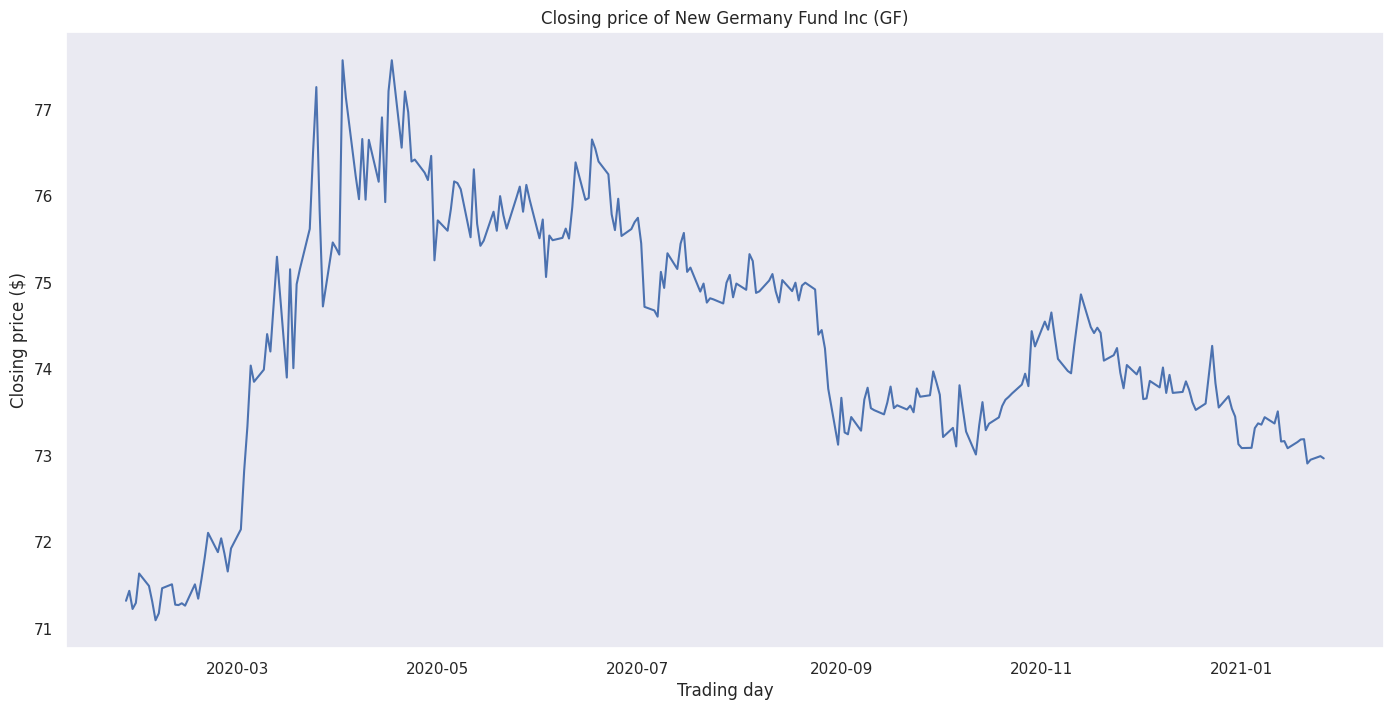

In [ ]:
plt.figure(figsize=(17, 8))
plt.plot(data.Close)
plt.title('Closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

In [ ]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

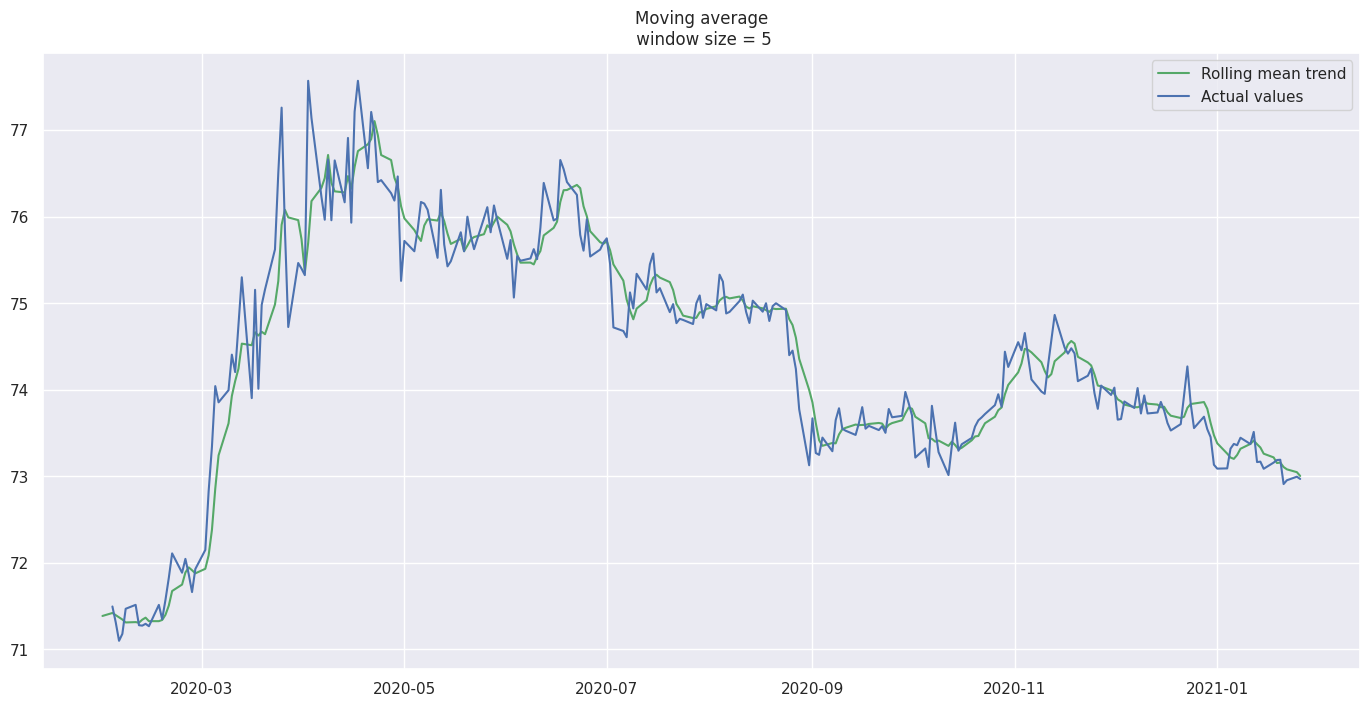

In [ ]:
#Smooth by the previous 5 days (by week)
plot_moving_average(data.Close, 5)

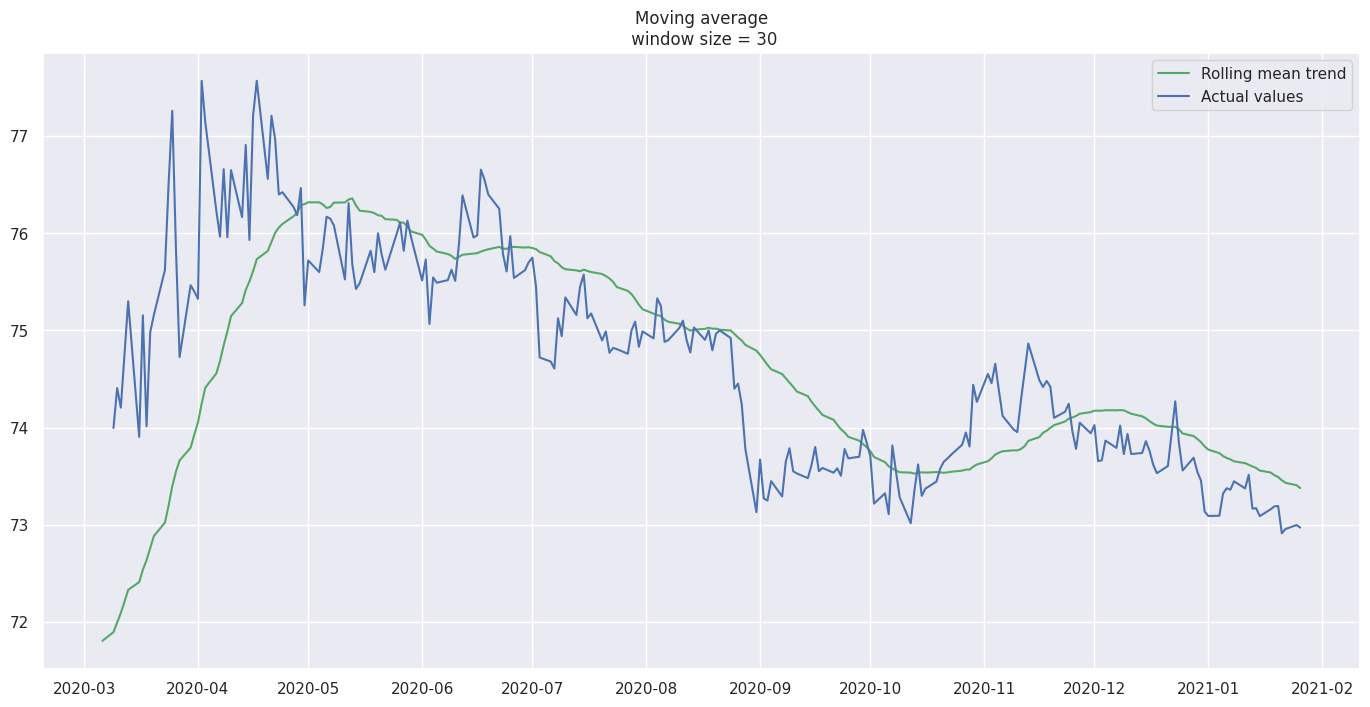

In [ ]:
#Smooth by the previous month (30 days)
plot_moving_average(data.Close, 30)

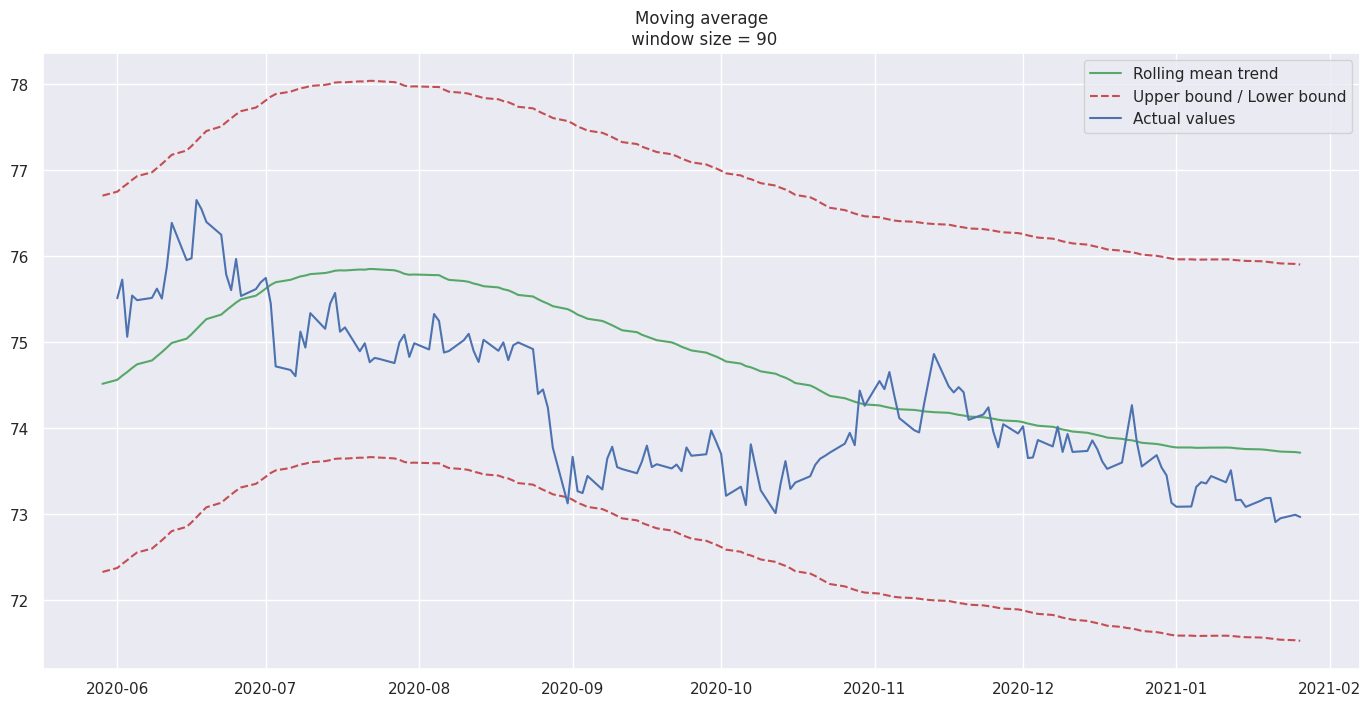

In [ ]:
#Smooth by previous quarter (90 days)
plot_moving_average(data.Close, 90, plot_intervals=True)

In [ ]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [ ]:
def plot_exponential_smoothing(series, alphas):

    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

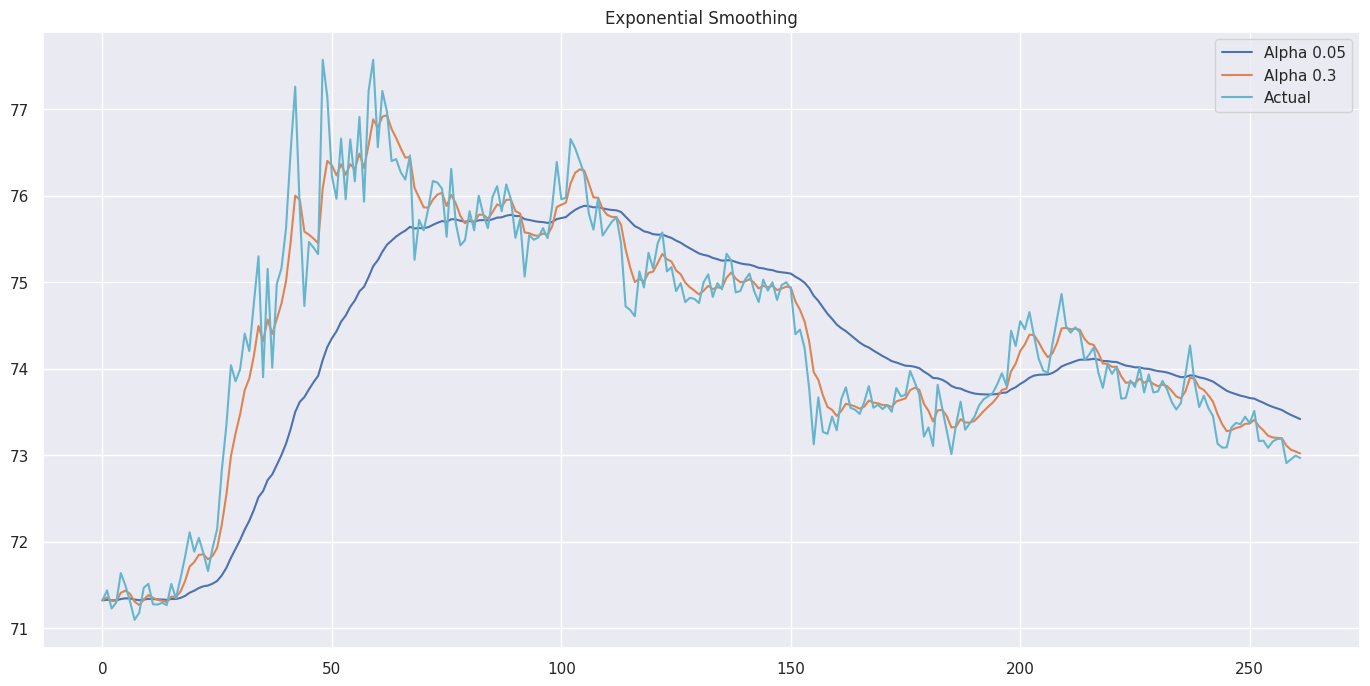

In [ ]:
plot_exponential_smoothing(data.Close, [0.05, 0.3])

In [ ]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [ ]:
def plot_double_exponential_smoothing(series, alphas, betas):

    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

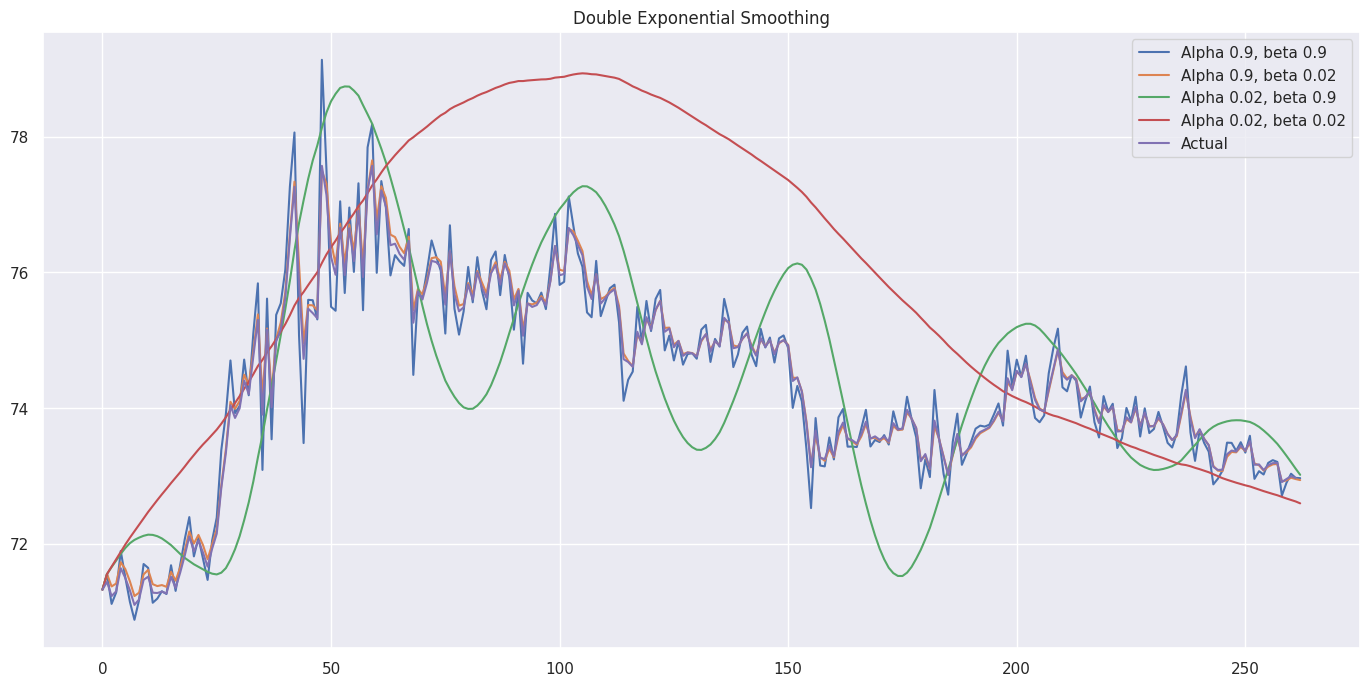

In [ ]:
plot_double_exponential_smoothing(data.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

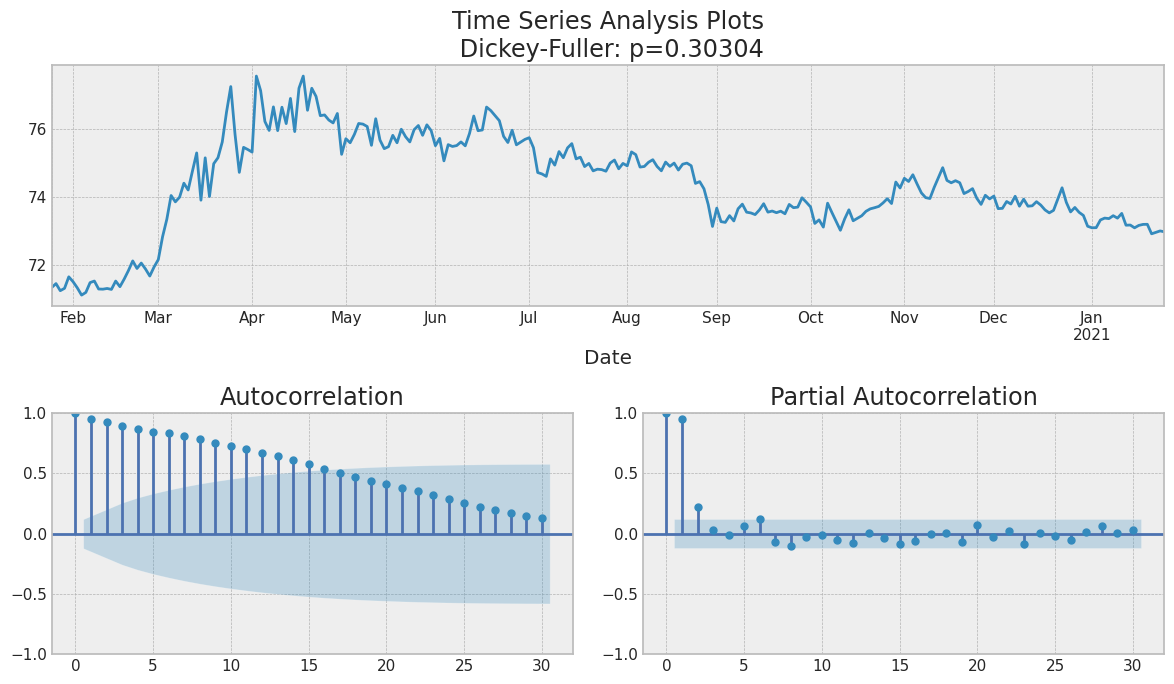

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(data.Close, lags=30)

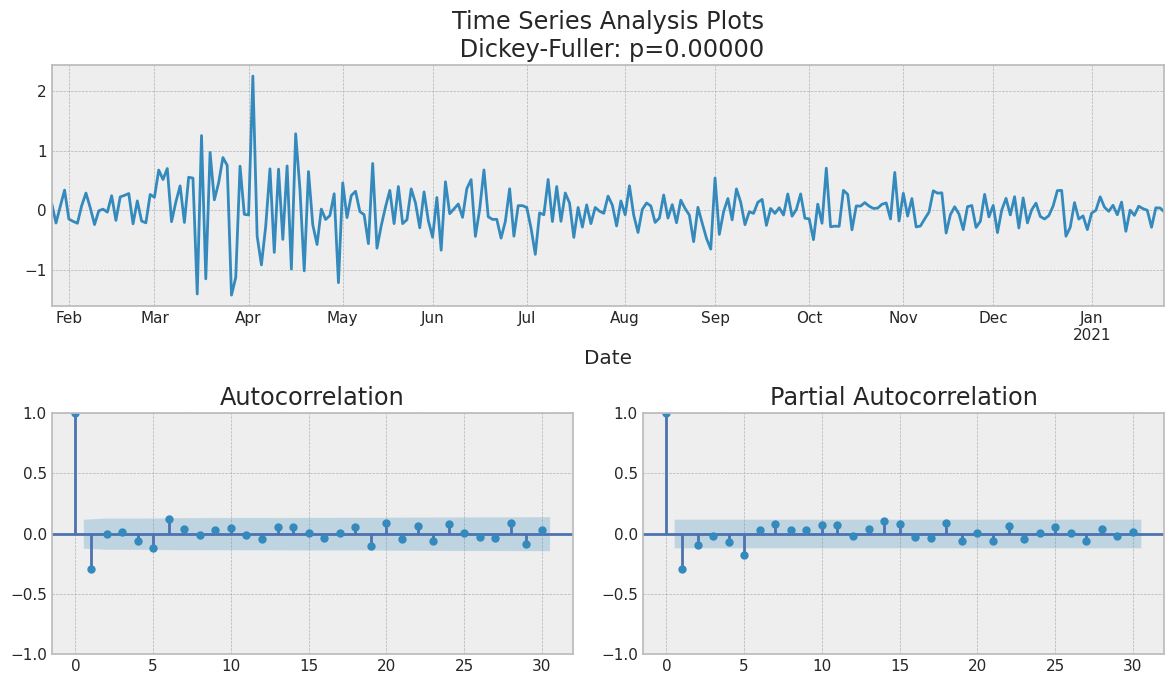

In [ ]:
data_diff = data.Close - data.Close.shift(1)

tsplot(data_diff[1:], lags=30)

In [ ]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [ ]:
comparison = pd.DataFrame({'actual': [18.93, 19.23, 19.08, 19.17, 19.11, 19.12],
                          'predicted': [18.96, 18.97, 18.96, 18.92, 18.94, 18.92]},
                          index = pd.date_range(start='2018-06-05', periods=6,))

In [ ]:
comparison.head()

,actual,predicted
2018-06-05,18.93,18.96
2018-06-06,19.23,18.97
2018-06-07,19.08,18.96
2018-06-08,19.17,18.92
2018-06-09,19.11,18.94


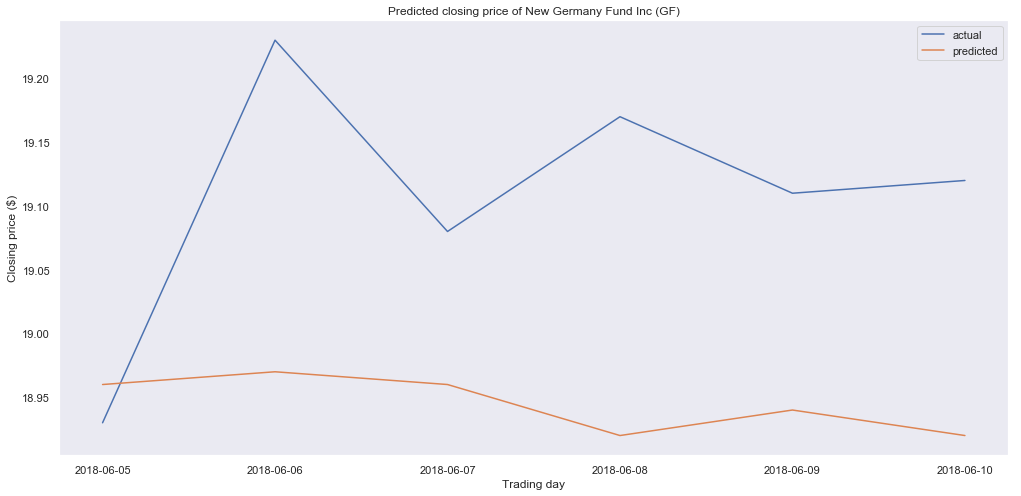

In [ ]:
plt.figure(figsize=(17, 8))
plt.plot(comparison.actual)
plt.plot(comparison.predicted)
plt.title('Predicted closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.legend(loc='best')
plt.grid(False)
plt.show()